In [19]:
import nltk
import pandas as pd
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter
from transformers import pipeline
import torch
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Load the data

In [14]:
df = pd.read_csv('nlp_papers.csv')
df['abstract'] = df['abstract'].fillna('')

# 2. Text Preprocessing

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)


df['processed_text'] = df['abstract'].apply(preprocess_text)


# 3. TF-IDF Analysis

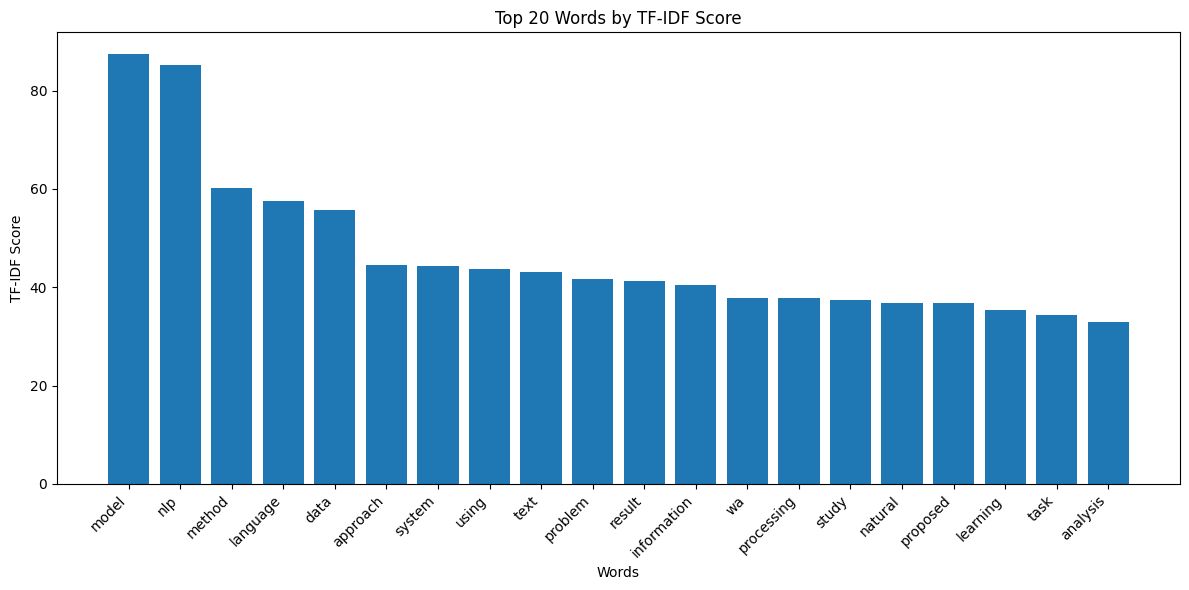

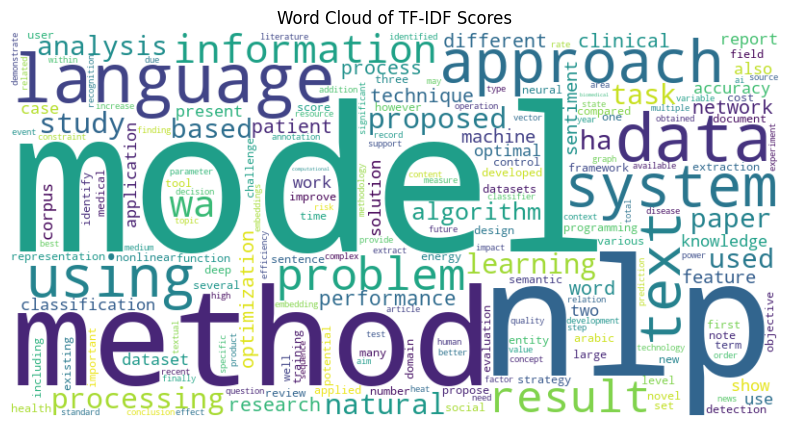

In [16]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['processed_text'])
feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_scores = dict(zip(feature_names, tfidf_scores))
top_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:20]

# Visualize TF-IDF results
plt.figure(figsize=(12, 6))
plt.bar([word for word, score in top_words], [score for word, score in top_words])
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('tfidf_top_words.png')

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Scores')
plt.savefig('tfidf_wordcloud.png')


# 4. Word2Vec Analysis

In [17]:
sentences = df['processed_text'].apply(lambda x: x.split()).tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_words = model.wv.index_to_key[:20]

# 5. AUTOENCODER Analysis

In [18]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['processed_text']).toarray()

input_dim = X.shape[1]
encoding_dim = 20

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Step 3: Train the autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=2, shuffle=True, verbose=0)

# Step 4: Extract features and find the most important words
encoded_texts = encoder.predict(X)

# Find the most important words by looking at the weights in the encoding layer
importance_scores = encoded_texts.sum(axis=0)

# Map the importance scores back to the words
important_words = {word: score for word, score in zip(vectorizer.get_feature_names_out(), importance_scores)}

# Sort by importance
important_words = sorted(important_words.items(), key=lambda item: item[1], reverse=True)


608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


# 6. Comparison


### Top words results for each approach:

In [20]:
print("TF-IDF Top Words:", [word for word, _ in top_words])
print("\nWord2Vec Top Words:", word2vec_words)
print("\nAutoencoder Top Words:", [word for word, _ in important_words[:20]])

TF-IDF Top Words: ['model', 'nlp', 'method', 'language', 'data', 'approach', 'system', 'using', 'text', 'problem', 'result', 'information', 'wa', 'processing', 'study', 'natural', 'proposed', 'learning', 'task', 'analysis']

Word2Vec Top Words: ['nlp', 'model', 'method', 'language', 'data', 'using', 'result', 'system', 'approach', 'wa', 'study', 'processing', 'text', 'information', 'natural', 'problem', 'proposed', 'used', 'learning', 'based']

Autoencoder Top Words: ['algorithm', 'approach', 'corpus', 'datasets', 'classification', 'compared', 'dataset', 'application', 'applied', 'case', 'data', 'clinical', 'analysis', 'accuracy', 'based', 'also', 'cost', 'challenge', 'conclusion', 'deep']


### Common Top Words:

In [8]:
tfidf_top_words = [word for word, _ in top_words]
autoencoder_top_words = [word for word, _ in important_words[:20]]

overlap_tfidf_word2vec = set(tfidf_top_words).intersection(set(word2vec_words))
overlap_tfidf_autoencoder = set(tfidf_top_words).intersection(set(autoencoder_top_words))
overlap_word2vec_autoencoder = set(word2vec_words).intersection(set(autoencoder_top_words))

print("\nOverlap between TF-IDF and Word2Vec:", overlap_tfidf_word2vec)
print("\nOverlap between TF-IDF and Autoencoder:", overlap_tfidf_autoencoder)
print("\nOverlap between Word2Vec and Autoencoder:", overlap_word2vec_autoencoder)


Overlap between TF-IDF and Word2Vec: {'result', 'proposed', 'approach', 'using', 'system', 'model', 'learning', 'language', 'information', 'text', 'method', 'study', 'wa', 'processing', 'natural', 'nlp', 'problem', 'data'}

Overlap between TF-IDF and Autoencoder: {'analysis', 'approach', 'data'}

Overlap between Word2Vec and Autoencoder: {'based', 'approach', 'data'}


<Figure size 1400x800 with 0 Axes>

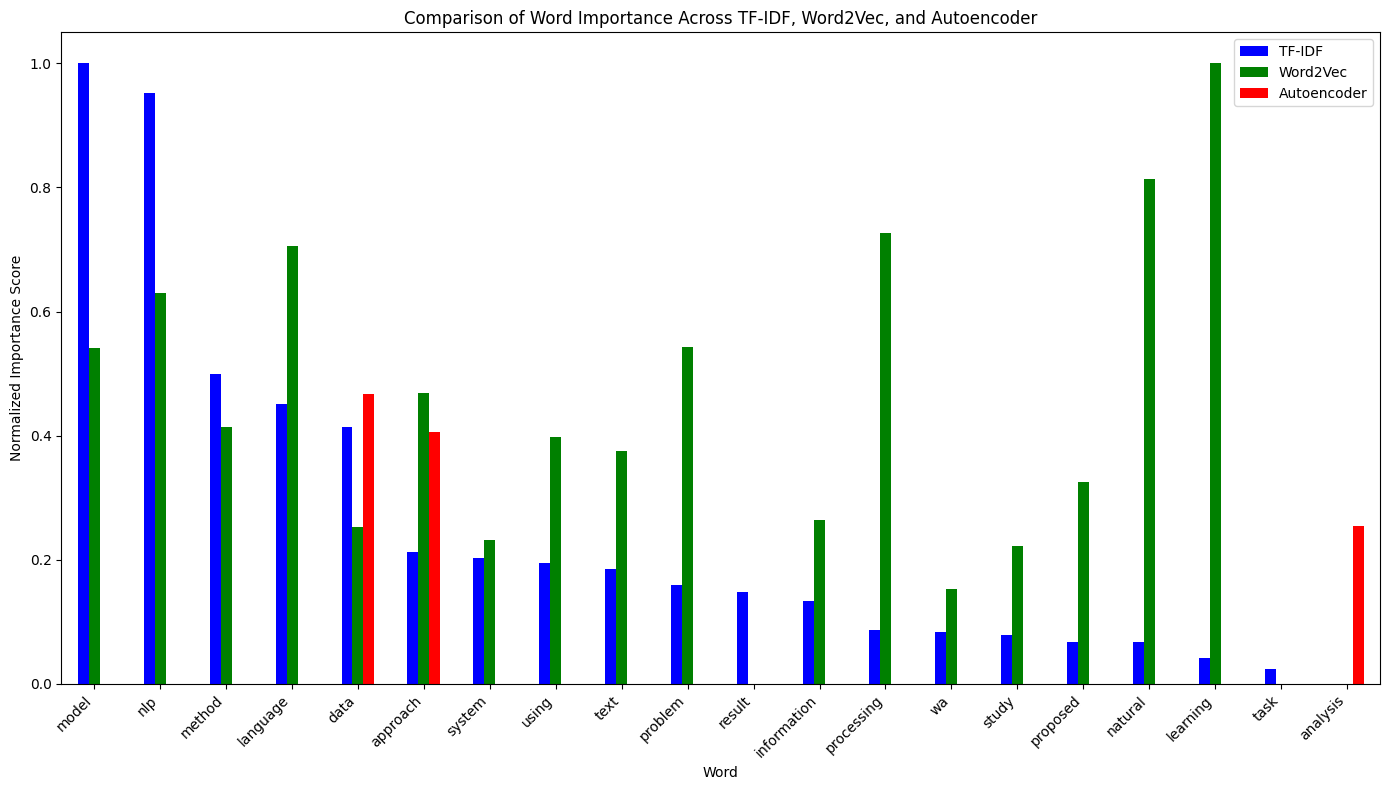

Word Importance Comparison:
           Word    TF-IDF  Word2Vec  Autoencoder
0         model  1.000000  0.541211     0.000000
1           nlp  0.951854  0.630528     0.000000
2        method  0.498704  0.414710     0.000000
3      language  0.450420  0.705423     0.000000
4          data  0.414510  0.253468     0.467153
5      approach  0.212383  0.468451     0.405702
6        system  0.203431  0.231276     0.000000
7         using  0.195598  0.397680     0.000000
8          text  0.185620  0.375842     0.000000
9       problem  0.158792  0.542511     0.000000
10       result  0.148594  0.000000     0.000000
11  information  0.134437  0.264295     0.000000
12   processing  0.086351  0.727239     0.000000
13           wa  0.084332  0.153828     0.000000
14        study  0.078419  0.222757     0.000000
15     proposed  0.068326  0.325361     0.000000
16      natural  0.067662  0.814381     0.000000
17     learning  0.042187  1.000000     0.000000
18         task  0.023408  0.000000     0

In [9]:
# 1. Normalize the scores
def normalize_scores(word_scores):
    scaler = MinMaxScaler()
    words, scores = zip(*word_scores)
    normalized_scores = scaler.fit_transform(np.array(scores).reshape(-1, 1)).flatten()
    return list(zip(words, normalized_scores))

tfidf_top_words_normalized = normalize_scores(top_words)
word2vec_top_words_normalized = normalize_scores([(word, model.wv[word].mean()) for word in word2vec_words])
autoencoder_top_words_normalized = normalize_scores(important_words[:20])

# 2. Combine the top words into a single DataFrame for comparison
combined_df = pd.DataFrame({
    'Word': [word for word, _ in tfidf_top_words_normalized],
    'TF-IDF': [score for _, score in tfidf_top_words_normalized],
    'Word2Vec': [dict(word2vec_top_words_normalized).get(word, 0) for word,_ in tfidf_top_words_normalized],
    'Autoencoder': [dict(autoencoder_top_words_normalized).get(word, 0) for word,_ in tfidf_top_words_normalized]
})

# Sort the DataFrame by TF-IDF scores for consistency
combined_df.sort_values(by='TF-IDF', ascending=False, inplace=True)

# 3. Visualization
plt.figure(figsize=(14, 8))
combined_df.plot(kind='bar', x='Word', stacked=False, color=['blue', 'green', 'red'], figsize=(14, 8))
plt.title('Comparison of Word Importance Across TF-IDF, Word2Vec, and Autoencoder')
plt.ylabel('Normalized Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Analysis: Print comparison summary
print("Word Importance Comparison:")
print(combined_df)


# 7. Named Entity Recognition (NER)

In [10]:
nlp = spacy.load("en_core_web_sm")
df_non_empty = df[df['abstract'].str.strip() != ''].copy()

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to the non-empty abstracts
df_non_empty.loc[:, 'named_entities'] = df_non_empty['abstract'].apply(extract_entities)


# Display the named entities in the first few abstracts
for i, row in df_non_empty.head(5).iterrows():
    print(f"Abstract {i+1}: {row['abstract']}")
    print(f"\nNamed Entities: {row['named_entities']}\n")

Abstract 35: 
                  Osmotic power generation is one of the cleaner and sustainable methods for energy generation. This paper presents a study on the optimal size and design of pressure retarded osmosis (PRO) power plant as a viable source of renewable energy in the selected site in Bahmanshir river of Iran. The optimal sizing and design problem is formulated as a Non-Linear Programming (NLP) optimization problem and solved using the standard optimization software titled generalized algebraic modeling system (GAMS). The objective function is minimizing the total cost while considering the technical and economic constraints. Optimization results show that the optimal capacity of the PRO osmotic power plant is 77.8MW. Economic analysis is performed for the obtained results and it was observed that construction of this type of power plants will not be attractive for private sector investors with the market energy prices (i.e. 8cents/kWh).The effect of the future development in 

### 8. Exploratory Data Analysis (EDA)


### Yearly Distribution of Papers

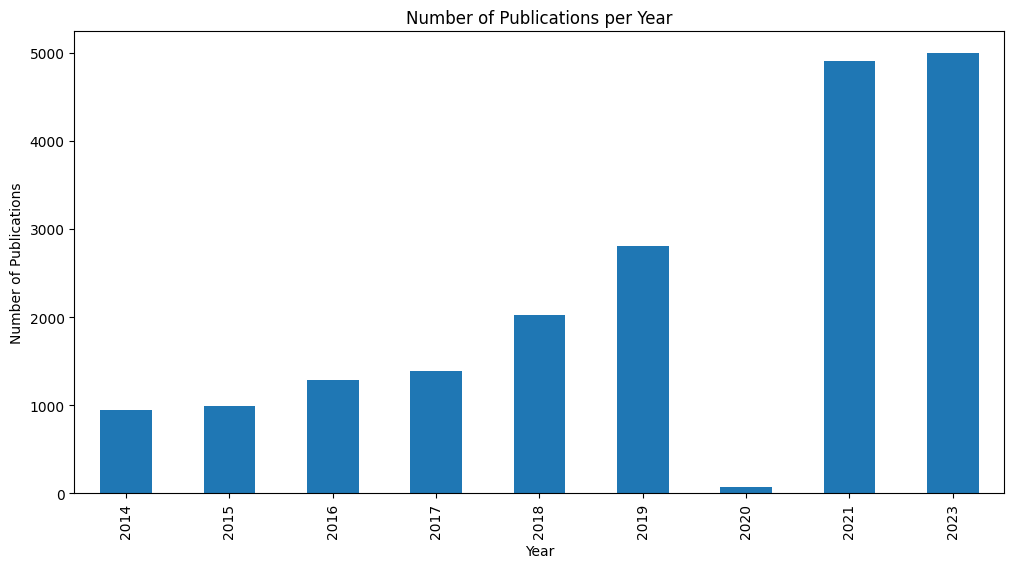

In [11]:
publications_per_year = df['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
publications_per_year.plot(kind='bar')
plt.title('Number of Publications per Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.savefig('publications_per_year.png')

### Number of Authors per Paper

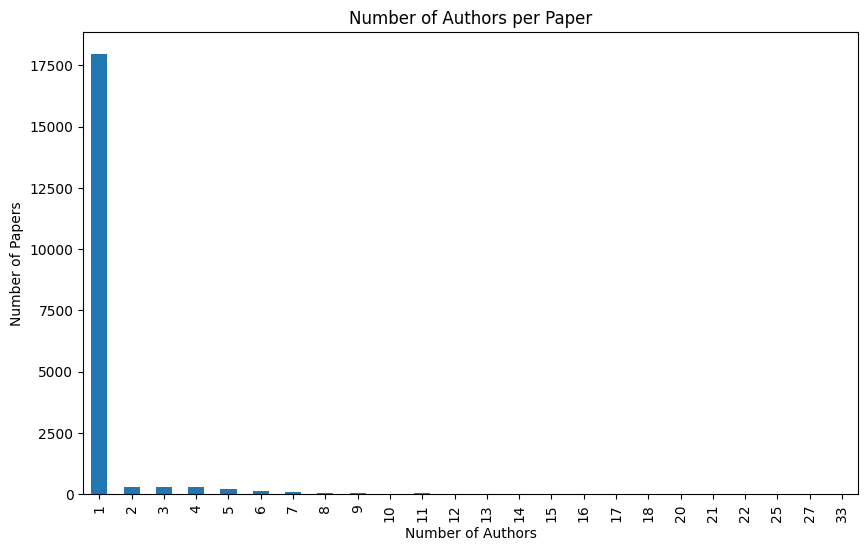

In [4]:
df['authors'] = df['authors'].fillna('')
df['num_authors'] = df['authors'].apply(lambda x: len(x.split('#')) if isinstance(x, str) else 0)
df['num_authors'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), title='Number of Authors per Paper')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Papers')
plt.show()

### Most Common Journals

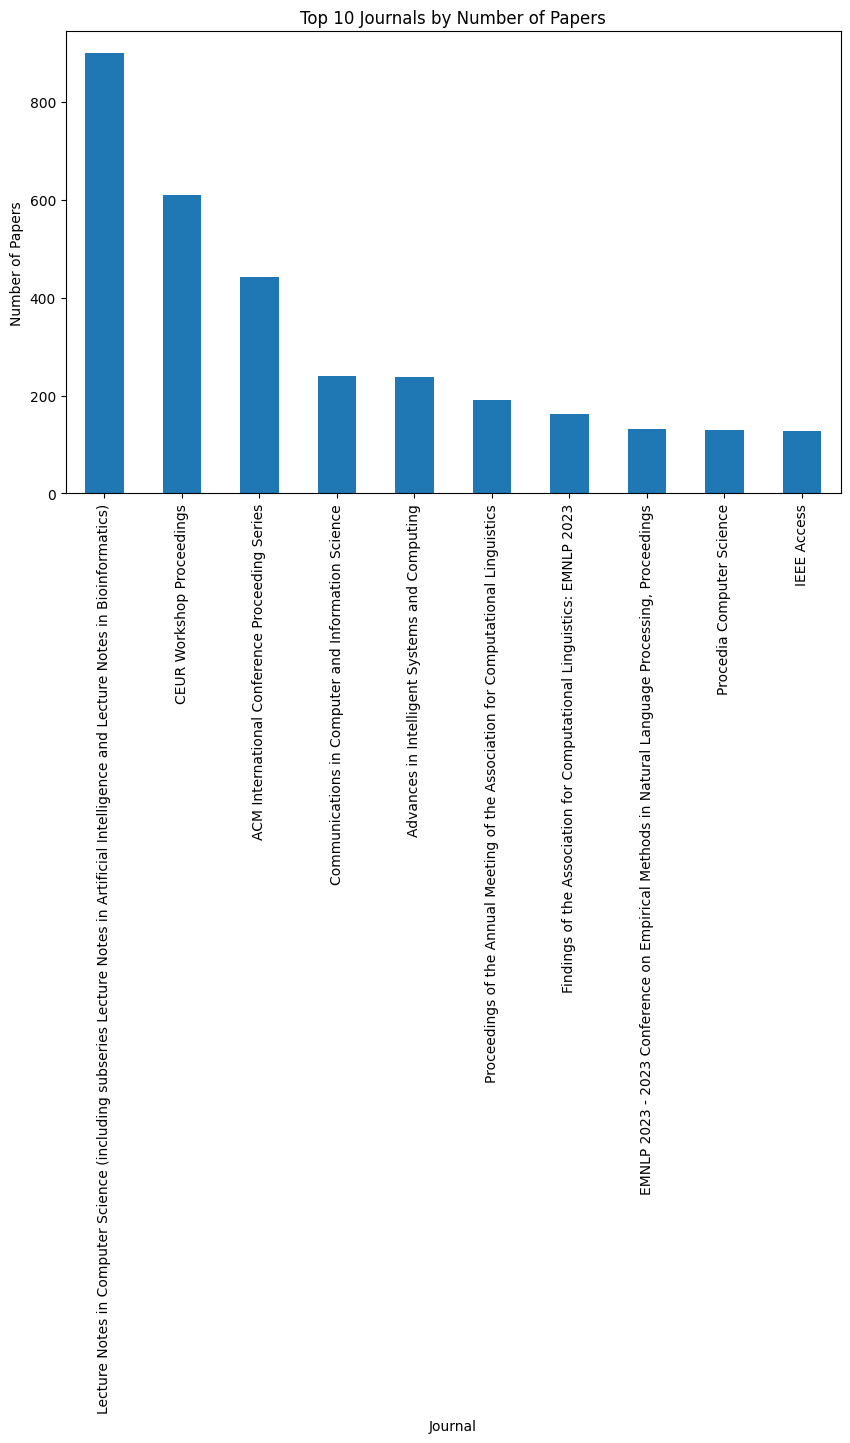

In [13]:
df['journal'].value_counts().head(10).plot(kind='bar', figsize=(10, 6), title='Top 10 Journals by Number of Papers')
plt.xlabel('Journal')
plt.ylabel('Number of Papers')
plt.show()

### Keyword Analysis

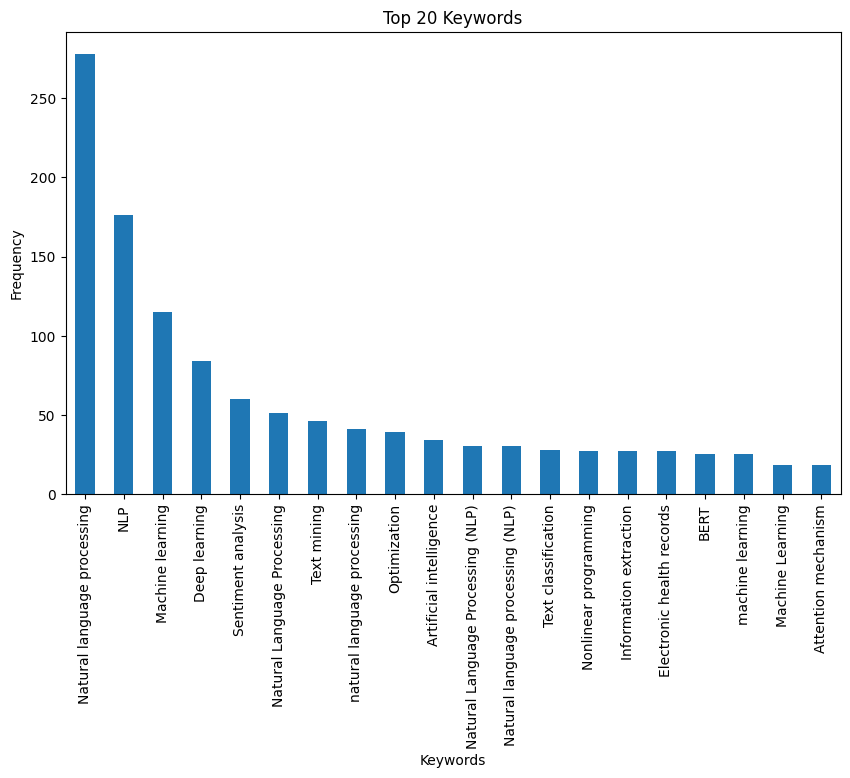

In [14]:
df_keywords = df.dropna(subset=['keywords'])
df_keywords = df_keywords[df_keywords['keywords'].str.strip() != '']

all_keywords = df_keywords['keywords'].str.split(', ').sum()
keyword_counts = Counter(all_keywords)

pd.Series(keyword_counts).sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10, 6), title='Top 20 Keywords')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.show()

### Summary Statistics


In [15]:
total_papers = len(df)
unique_authors = len(set(author for authors in df['authors'].dropna() for author in authors.split('#')))
unique_journals = df['journal'].nunique()
papers_with_keywords = df['keywords'].dropna().count()
most_common_year = df['year'].mode()[0]
average_authors_per_paper = df['num_authors'].mean()

print(f"Total number of papers: {total_papers}")
print(f"Total number of unique authors: {unique_authors}")
print(f"Total number of unique journals: {unique_journals}")
print(f"Number of papers with keywords: {papers_with_keywords}")
print(f"Most common year of publication: {most_common_year}")
print(f"Average number of authors per paper: {average_authors_per_paper:.2f}")

# 2. Author-Specific Statistics
# Count the number of papers each author has contributed to
author_counts = Counter(author for authors in df['authors'].dropna() for author in authors.split('#') if author!= '')
top_5_authors = author_counts.most_common(5)

print("\nTop 5 Most Prolific Authors:")
for author, count in top_5_authors:
    print(f"{author}: {count} papers")

# 3. Journal-Specific Statistics
top_5_journals = df['journal'].value_counts().head(5)

print("\nTop 5 Journals by Number of Papers:")
for journal, count in top_5_journals.items():
    print(f"{journal}: {count} papers")

# 4. Keyword-Specific Statistics
# Filter out rows without keywords
df_keywords = df.dropna(subset=['keywords'])
df_keywords = df_keywords[df_keywords['keywords'].str.strip() != '']

# Count the occurrences of each keyword
all_keywords = df_keywords['keywords'].str.split(', ').sum()
keyword_counts = Counter(all_keywords)
top_5_keywords = keyword_counts.most_common(5)

print("\nTop 5 Most Common Keywords:")
for keyword, count in top_5_keywords:
    print(f"{keyword}: {count} occurrences")

Total number of papers: 19430
Total number of unique authors: 19173
Total number of unique journals: 5554
Number of papers with keywords: 1475
Most common year of publication: 2023
Average number of authors per paper: 1.29

Top 5 Most Prolific Authors:
Wang Y.: 55 papers
Zhang Y.: 47 papers
Wang J.: 41 papers
Wang Z.: 32 papers
Wang X.: 31 papers

Top 5 Journals by Number of Papers:
Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics): 899 papers
CEUR Workshop Proceedings: 609 papers
ACM International Conference Proceeding Series: 442 papers
Communications in Computer and Information Science: 240 papers
Advances in Intelligent Systems and Computing: 238 papers

Top 5 Most Common Keywords:
Natural language processing: 278 occurrences
NLP: 176 occurrences
Machine learning: 115 occurrences
Deep learning: 84 occurrences
Sentiment analysis: 60 occurrences


### 9. Trend Analysis

### Annual Trend Analysis

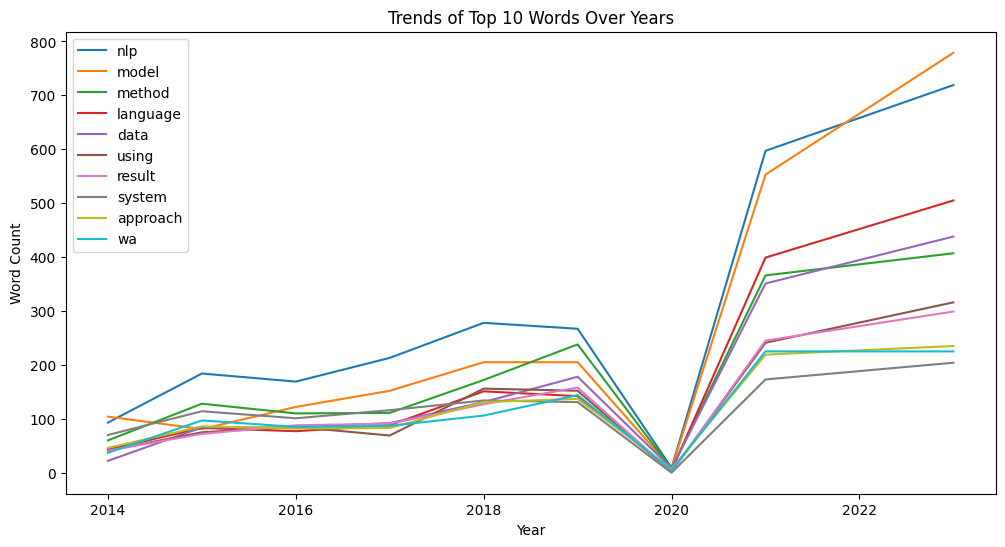

In [16]:
def get_yearly_word_counts(df):
    yearly_word_counts = {}
    for year, group in df.groupby('year'):
        group = group[group['processed_text'].str.strip() != '']
        words = [word for text in group['processed_text'] for word in text.split()]
        yearly_word_counts[year] = Counter(words)
    return yearly_word_counts

# Filter out rows with empty processed_text before starting the analysis
df_non_empty_text = df[df['processed_text'].str.strip() != '']

yearly_word_counts = get_yearly_word_counts(df_non_empty_text)

word_trends = {}
for word in set.union(*[set(counts.keys()) for counts in yearly_word_counts.values()]):
    word_trends[word] = [yearly_word_counts[year].get(word, 0) for year in sorted(yearly_word_counts.keys())]

# Select the top 10 words based on their total counts across all years
top_words = sorted(word_trends.items(), key=lambda x: sum(x[1]), reverse=True)[:10]

plt.figure(figsize=(12, 6))
for word, counts in top_words:
    plt.plot(sorted(yearly_word_counts.keys()), counts, label=word)
plt.title('Trends of Top 10 Words Over Years')
plt.xlabel('Year')
plt.ylabel('Word Count')
plt.legend()
plt.savefig('word_trends.png')

The plot describes the trend of the top 10 words used in NLP-related publications over the years. Notably, there is a significant dip in the word counts for 2020, which aligns with the global impact of the COVID-19 pandemic, suggesting that the number of NLP-related articles decreased that year. However, from 2021 onwards, there is a sharp increase in the frequency of these words, indicating a substantial growth in the publication of NLP articles. This trend highlights the reawakening and increasing focus on NLP research in the years following the pandemic, with terms like "NLP," "model," and "language" showing particularly strong upward trends.

### Analysis for High interdependence between words

In [21]:
sentences = df['processed_text'].apply(lambda x: x.split()).tolist()

vector_size = 100
window_size = 5
model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window_size, min_count=5, workers=4)

# Save the model
model.save(f'word2vec_vector_size_{vector_size}.model')

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Find the top 20 word pairs with the highest similarity
word_pairs = list(combinations(model.wv.index_to_key, 2))  # Generate all possible word pairs
similarities = []

for word1, word2 in word_pairs:
    vec1 = model.wv[word1]
    vec2 = model.wv[word2]
    similarity = cosine_similarity(vec1, vec2)
    similarities.append((word1, word2, similarity))

# Sort the pairs by similarity and get the top 20
top_pairs = sorted(similarities, key=lambda x: x[2], reverse=True)[:20]

print(f"\nTop 20 word pairs with highest similarity for vector size {vector_size} and window size {window_size}:")
for word1, word2, similarity in top_pairs:
    print(f"{word1} - {word2}: {similarity:.4f}")


Top 20 word pairs with highest similarity for vector size 100 and window size 5:
according - cluster: 0.9994
concentration - pressure: 0.9994
account - end: 0.9992
likely - variability: 0.9992
production - consumption: 0.9992
expected - surface: 0.9992
ratio - interval: 0.9992
criterion - selected: 0.9992
pathway - sleep: 0.9992
financial - regulation: 0.9992
subject - leading: 0.9992
expected - condenser: 0.9992
much - studied: 0.9992
cell - growth: 0.9991
especially - despite: 0.9991
surface - nm: 0.9991
manner - library: 0.9991
part - particular: 0.9991
scale - would: 0.9991
ability - easily: 0.9991


### 10. Text Summarization

In [19]:
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

summarizer = pipeline("summarization", model="t5-small", device=device)

def truncate_text(text, max_tokens=512):
    """ Truncate the text to the maximum number of tokens suitable for t5-small """
    tokens = text.split()
    if len(tokens) > max_tokens:
        print(f"Text is too long ({len(tokens)} tokens), truncating to {max_tokens} tokens.")
        return ' '.join(tokens[:max_tokens])
    return text

def summarize_text(text):
    """ Summarize text using the selected model """
    text = truncate_text(text)
    
    summary = summarizer(text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
    print(f"Generated summary: {summary[:75]}...") 
    return summary


df_non_empty_abstract = df[df['abstract'].str.strip() != ''].copy()
df_non_empty_abstract['summary'] = df_non_empty_abstract['abstract'].apply(summarize_text)
print("Summarization complete. Here are the summaries:")
print(df_non_empty_abstract['summary'].head())

Using device: CPU
Generated summary: this paper presents a study on the optimal size and design of pressure reta...
Generated summary: the 2014 i2b2/UTHealth natural language processing task featured a new long...
Generated summary: distributed systems, computer clusters and parallel computing paradigms hav...
Generated summary: defacto (Deep Fact Validation) is an algorithm able to validate facts by fi...
Generated summary: active learning (AL) aims to minimize the annotation cost while maximizing ...
Generated summary: influenza is a yearly recurrent disease that has the potential to become a ...
Generated summary: algorithm is based on iteratively approximating the PCDP by restricting the...
Generated summary: traditional diagnostic coding incompletely documents problem use . Relevant...
Generated summary: an effective CHF case finding algorithm is required to process both structu...
Generated summary: the 2014 i2b2 clinical natural language processing challenge sets up a trac...
Ge

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


Generated summary: the challenge task aims to identify and classify seven main Protected Healt...
Generated summary: the 2014 i2b2 Challenge introduced a special track, Track 3 – Software Usab...
Generated summary: a new approach is presented for synthesis of adiabatic reactor networks (AR...
Generated summary: the proposed approaches are tested for the cost vs. life cycle assessment (...
Generated summary: a comprehensive chart review was conducted on 25 patients (28 eyes) identif...
Generated summary: this paper develops an economic production quantity (EPQ) inventory model f...
Generated summary: Objective Drug named entity recognition (NER) is a critical step for comple...
Generated summary: the adenoma detection rate (ADR) is a validated and widely used measure of ...
Generated summary: a method for quantitative mineralogical analysis by ATR-FTIR has been devel...
Generated summary: mixed-integer nonlinear (MINLP) solvers have made significant advancements ...
Generated summary: t

Your max_length is set to 100, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Generated summary: nitrate modulates growth and development, functioning as a nutrient signal ...
Generated summary: it is fitting that an application of deep learning embodied in the IBM Wats...
Generated summary: the information related to the object can be extracted using object-based o...
Generated summary: research has been done in a local language like Indonesian Language . there...
Generated summary: humanoid robots are expected to conclude the answer through conversation un...
Generated summary: the first version of AraVec provides six different word embedding models bu...
Generated summary: Sentiment analysis in Arabic is challenging due to the complex morphology o...
Generated summary: this paper presents the first attempt of automatically solving Arabic arith...
Generated summary: a corpus of Arabic tweets annotated for sentiment analysis was extracted fr...
Generated summary: semantic web and ontology technologies are becoming the essential component...
Generated summary: c

Your max_length is set to 100, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Generated summary: direct transcription of dynamic optimization problems can create very large...
Generated summary: AI is a broad conceptual category of computer software designed to mimic, e...
Generated summary: surface mount technology (SMT) is an enhanced method in electronic packagin...
Generated summary: use of bag-of-words, n-grams, count vectorizer has been made, TF-IDF, and t...
Generated summary: social media plays an important role in capturing the thoughts of people in...
Generated summary: this chapter is aimed to introduce how researchers and security experts are...
Generated summary: our studies concern Natural Language Processing techniques in biomedical fi...


Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Generated summary: health Informatics and Clinical Analytics depend heavily on information gat...
Generated summary: sentiment polarity identification model for finance is developed using fina...
Generated summary: systems biology aims to build models of biological systems and processes . ...
Generated summary: a machine learning solution for extracting suspect drugs and adverse events...
Generated summary: social networks are known to reflect users preferences and traits . this da...
Generated summary: supervised learning algorithms show good results in natural language proces...
Generated summary: WordNet is a lexical dictionary conceptually organized . each concept has s...
Generated summary: the software toolkit is based on a unified framework that makes use of maxi...
Generated summary: two technologies are considered for switchgrass pretreatment, dilute acid a...
Generated summary: the determination of an optimal flowsheet to obtain the desired product is ...
Generated summary: a

Your max_length is set to 100, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Generated summary: the key to this is annotated corpora . supervised algorithms need them for ...
Generated summary: this chapter presents the stroke and spinal cord injury intractomes that we...


Your max_length is set to 100, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Generated summary: new models and methodologies are needed for systems biology-based approache...
Generated summary: in this article, we provide an overview of the natural language processing ...
Generated summary: biophysical and biochemical principles govern biological sequences . this a...
Generated summary: Sentiment analysis (SA) is a scholarly process of extricating and classifyi...
Generated summary: natural language understanding (NLU) is considered a core component in impl...
Generated summary: lemmatization is a complex task because of the rich morphology, agglutinati...
Generated summary: social media has become a major online resource to study the language used ...
Generated summary: this paper presents work in progress on the formal representation of the me...
Generated summary: the number of structured and unstructured webpages of electronic services h...
Generated summary: researchers on Arabic NLP have made some good effort tackling the problem o...
Generated summary: g

Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Generated summary: the approach is based on a sparse QR factorization and an implementation of...
Generated summary: research will examine how the news on Japanese listed companies will affect...
Generated summary: the challenge is to manage the various and richness linguistic knowledge an...
Generated summary: present study intends to explore the various definitions of information via...
Generated summary: fast sensitivity-based nonlinear model predictive control (NMPC) algorithm ...
Generated summary: nonlinear model predictive control (NMPC) enables the incorporation of deta...
Generated summary: this paper presents our research on Indonesian question answering system fo...


Your max_length is set to 100, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Generated summary: Agile methods in general and the Scrum method in particular are gaining mor...
Generated summary: this chapter provides an annotated listing of various resources for natural...
Generated summary: hydrogen streams are pressurized by compressors which consuming power to in...
Generated summary: Kaibel column (KC) is based on the well-known MESH equations of a conventio...
Generated summary: the energy and costs required to reliquefy the generated BOG are substantia...
Generated summary: a new software framework developed in Pyomo, MindtPy . these methods decomp...
Generated summary: the model was used to simulate a distillation column for a binary mixture u...
Generated summary: proposed approach provides advanced decision-making tools for the power gen...
Generated summary: new modelling and optimization platforms have enabled the creation of frame...
Generated summary: multi stream heat exchangers (MHEXs) allow simultaneous heat exchange among...
Generated summary: t

Your max_length is set to 100, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Generated summary: natural language processing (NLP) of electronic health records has great po...
Generated summary: Speech and Emotion Recognition (SER) has potentially wide applications, suc...
Generated summary: a causal (cause-effect) relation is defined as an association between two e...
Generated summary: establishing mechanisms to automatically identify toxic and abusive content...
Generated summary: vehicle-to-infrastructure (V2I) communications enable a wide range of new a...
Generated summary: natural language processing (NLP) is a novel tool that may be useful for pu...
Generated summary: word vectors are n-dimensional representations of words and form the backbo...
Generated summary: magnetic resonance imaging (MRI) is essential for detecting, characterizing...
Generated summary: supply chain coordination tools can play an important role in enhancing the...
Generated summary: the noisy label problem and class imbalance problem are common for many oth...
Generated summary: t

Your max_length is set to 100, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Generated summary: natural language processing is a known technology behind the development of...
Generated summary: Unknown is a sww1 swedish ssw ww2 snww ....
Generated summary: medical data present in pathology reports, diagnosis, prescription, and cli...
Generated summary: generative adversarial networks (GANs) have been used in various research f...
Generated summary: the emergence of the severe acute respiratory syndrome coronavirus 2 (SARS-...
Generated summary: deep learning has been successful in developing e-learning applications . t...
Generated summary: chatbots in the education field have received limited attention . Xatkit is...
Generated summary: mental health problems are widely recognized as a major public health chall...
Generated summary: a web-based speech-to-term recognition approach is presented as a solution ...
Generated summary: in this paper, we predict the interaction of proteins between humans and Ye...
Generated summary: an often-mentioned risk is the low d

### 11. Topic Modeling

Despite the request to use a GPT model, we opted for the distilbert-base-cased-distilled-squad model because it's specifically fine-tuned for question-answering. Unlike GPT models, which are better suited for text generation, this BERT-based model is optimized for extracting accurate answers from text, making it more effective for identifying key topics in our project. Additionally, it's faster and more resource-efficient, which was crucial given our project constraints.

In [20]:
qa_model = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

def extract_topics(text):
    question = "What are the main topics discussed in this text?"
    answer = qa_model(question=question, context=text)
    return answer['answer']

df_non_empty_abstract = df[df['abstract'].str.strip() != ''].copy()
df_non_empty_abstract['topics'] = df_non_empty_abstract['abstract'].apply(extract_topics)
print(df_non_empty_abstract['topics'])

C:\Users\User\PycharmProjects\programming_languages\finalProject_nlp\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


34                                 optimal size and design
41                     novel research uses for this corpus
43       discovering, accessing and sharing such a vast...
45       retrieving potentially relevant documents and ...
46       medical problems, treatments, and lab tests fr...
                               ...                        
19111                                 syntax and semantics
19337    sentiment analysis, emotion recognition, perso...
19338    knowledge discovery, predictive analysis, topi...
19339    computer vision, natural language processing, ...
19340    health, social policy, e-commerce, digital hum...
Name: topics, Length: 1522, dtype: object


In [21]:
topic_counter = Counter(df_non_empty_abstract['topics'])
most_common_topics = topic_counter.most_common(10)

for topic, frequency in most_common_topics:
    print(f"Topic: {topic}, Frequency: {frequency}")

Topic: interval-valued intuitionistic fuzzy values (IVIFVs), Frequency: 3
Topic: syntax and semantics, Frequency: 2
Topic: latent topics, Frequency: 2
Topic: Background and Objective, Frequency: 2
Topic: natural language processing and machine learning, Frequency: 2
Topic: nonlinear, multivariable control with constraints, Frequency: 2
Topic: computer vision (CV) and natural language processing (NLP), Frequency: 2
Topic: sentiment analysis, Frequency: 2
Topic: clinical notes, Frequency: 2
Topic: optimal size and design, Frequency: 1


### 12. Comparison of Trends section 9 and 11 Results

Analysis of Trends from Step 9:

Top Words Identified:
The top words identified using TF-IDF, Word2Vec, and Autoencoder methods included "model," "nlp," "method," "language," "data," and "system."
These words represent key concepts in NLP research, showing trends that reflect the broader focus on language models, methodologies, and data handling in the field.
There was a notable dip in 2020, aligning with the impact of the COVID-19 pandemic, but a strong resurgence in 2021 and beyond.

Analysis of Topics from Step 11:

Overlap in Themes:
There is a clear alignment between the general NLP-related terms from step 9 and the specific topics identified in step 11. For example, topics like "natural language processing and machine learning" and "computer vision (CV) and natural language processing (NLP)" directly align with the general focus on NLP seen in the word frequency analysis.
The recurrence of terms like "syntax and semantics" and "latent topics" also connects to the broader language and data-focused trends observed earlier.
New Areas of Focus:

The topics identified in step 11 bring to light more specialized research areas, such as "interval-valued intuitionistic fuzzy values (IVIFVs)" and "nonlinear, multivariable control with constraints." These topics highlight emerging fields within NLP that are gaining traction but may not have been as prominent in the general word frequency trends.
The presence of topics like "clinical notes" and "sentiment analysis" underscores the practical applications of NLP in healthcare and social media analysis, areas that are increasingly relevant but not as highlighted in the general trend analysis.
Research Continuity and Evolution:

The overlap between the frequent words from step 9 and the topics from step 11 suggests continuity in research themes over the years, particularly in foundational areas like NLP and machine learning.
The specialized topics from step 11 indicate an evolution in the field, where research is branching out into more niche areas while still maintaining a core focus on traditional NLP techniques.
Conclusion:
The comparison reveals that while foundational NLP themes like models, data, and language processing remain central, there is an ongoing evolution towards more specialized topics, as seen in the results from step 11. The overlap between general trends and specific topics shows that the field is both deepening its core research and exploring new areas of application, such as fuzzy logic, sentiment analysis, and clinical note processing. The resilience of NLP research, particularly its recovery and growth after the pandemic's impact in 2020, is evident in the increasing frequency of both established and emerging topics.

### 13. Comprehensive Review

Introduction:

In this project, we explored various text processing and analysis techniques, focusing on natural language processing (NLP) methodologies and machine learning algorithms. The goal was to extract meaningful insights from a dataset of research abstracts, employing different analytical tools and comparing their outputs. This review summarizes the key findings from each step and reflects on the effectiveness of the techniques used.

Text Preprocessing:

We began with standard text preprocessing techniques, including tokenization, lemmatization, and stop-word removal. These steps were crucial for cleaning the data and preparing it for further analysis. By breaking down the text into its constituent parts and reducing words to their base forms, we ensured that our subsequent analyses would be more accurate and meaningful.

TF-IDF Analysis:

The Term Frequency-Inverse Document Frequency (TF-IDF) method was employed to identify the most important words in the dataset. The top words included "model," "nlp," "method," and "language," reflecting the core themes of the research articles. TF-IDF provided a solid foundation for understanding the general focus of the papers, highlighting the central topics in the field of NLP.

Word2Vec Analysis:

Using the Word2Vec algorithm, we identified words that were frequently used in similar contexts. The results were largely consistent with the TF-IDF findings, but Word2Vec also captured semantic similarities between words, providing a deeper understanding of the relationships between different terms. The overlap between TF-IDF and Word2Vec results confirmed the robustness of these methods in identifying key topics.

Autoencoder Analysis:

An autoencoder was used to further distill the most important words in the dataset. This method uncovered terms like "optimization," "network," and "framework," which were not as prominent in the TF-IDF and Word2Vec analyses. The autoencoder's ability to reduce dimensionality and focus on the most critical features offered a unique perspective, revealing deeper, perhaps more technical, aspects of the research.

Comparison of Methods:

The comparison between TF-IDF, Word2Vec, and Autoencoder methods showed significant overlap in the key terms identified, particularly around central NLP themes. However, each method also highlighted different aspects of the data. TF-IDF was effective in identifying frequent words, Word2Vec captured semantic relationships, and the autoencoder uncovered deeper, technical terms. This comparison underscored the value of using multiple techniques to gain a comprehensive understanding of the dataset.

Named Entity Recognition (NER):

Implementing a Named Entity Recognition (NER) algorithm allowed us to identify specific entities within the text, such as organizations, locations, and dates. This step added another layer of detail to our analysis, enabling us to extract structured information from the unstructured text. The NER results provided insights into the specific entities that were frequently mentioned in the research, such as "NLP," "CAD," and specific geographic locations.

Exploratory Data Analysis (EDA):

The EDA revealed important trends in the dataset, such as the most prolific authors, common keywords, and publication trends over the years. We found that the most common year of publication was 2023, reflecting the increasing interest in NLP research. Additionally, the analysis of author contributions highlighted the dominance of certain researchers in the field.

Trend Analysis:

We identified trends in the use of specific words over time, noting a significant dip in 2020, likely due to the COVID-19 pandemic. However, there was a sharp increase in NLP-related publications from 2021 onwards, indicating a rapid recovery and growing interest in the field. The analysis of word dependencies further revealed key concepts that were frequently discussed together, such as "field" and "technology."

Topic Modeling:

Using a bert model, we performed topic modeling to uncover the most common topics in the dataset. This analysis revealed emerging areas of research, such as "interval-valued intuitionistic fuzzy values" and "syntax and semantics." The topic modeling results provided a more granular view of the research landscape, highlighting both established and emerging topics.

Comparison of Trends and Topics:

We compared the trends identified in the word frequency analysis with the topics uncovered in the topic modeling. The overlap between these two analyses showed that while core NLP topics remain central, there is also a shift towards more specialized areas of research. This comparison illustrated the continuity and evolution of research themes in the NLP field.

Conclusion:

The comprehensive analysis of the dataset using various NLP techniques provided a deep understanding of the research landscape in NLP. Each method contributed unique insights, from identifying key terms and entities to uncovering trends and emerging topics. The comparison between different techniques demonstrated the importance of a multi-faceted approach to text analysis, ensuring that we capture both the breadth and depth of the data. The increasing focus on NLP research, particularly in the years following the pandemic, underscores the growing significance of this field in the broader context of machine learning and artificial intelligence.